Зотов Роман Алексеевич 6132
<br>Тема лабораторной работы: линейная регрессия

In [78]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from itertools import combinations
from sklearn.feature_selection import SelectPercentile, mutual_info_classif, RFECV
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Задание 1

Нашел датасет, на котором хорошо видна линейность, жаль с прошлым не сраслось.

Переменные:
- Учебные часы : общее количество часов, потраченных каждым студентом на учебу.
- Предыдущие результаты : баллы, полученные учащимися на предыдущих тестах.
- Внеклассные мероприятия (категория): участвует ли ученик во внеклассных мероприятиях (Да или Нет).
- Часы сна : среднее количество часов сна студента в день.
- Образцы экзаменационных работ, которые выполнил студент : количество образцов экзаменационных работ, которые выполнил студент.

Предсказываем:
- Результат

In [79]:
df = pd.read_csv(f'Student_Performance.csv')
df = df.dropna()
df

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0
...,...,...,...,...,...,...
9995,1,49,Yes,4,2,23.0
9996,7,64,Yes,8,5,58.0
9997,6,83,Yes,8,5,74.0
9998,9,97,Yes,7,0,95.0


# Задание 2

In [80]:
data = df[['Hours Studied', 'Previous Scores', 'Sleep Hours', 'Sample Question Papers Practiced','Performance Index']].copy()
scaler = StandardScaler()
data_scaler = scaler.fit_transform(data)
df_scaler = pd.DataFrame(data_scaler, columns=['hours_studied_scaled', 'previous_scores_scaled', 'sleep_hours_scaled', 'sample_question_papers_practiced_scaled','performance_index_scaled'])
encoder = OneHotEncoder(drop='first',sparse_output=False, dtype=int)

numeric_features = ['hours_studied_scaled', 'previous_scores_scaled', 'sleep_hours_scaled', 'sample_question_papers_practiced_scaled']
categorical_features = ['Extracurricular Activities']
act_data = encoder.fit_transform(df[categorical_features])
act_df = pd.DataFrame(
    act_data,
    columns=encoder.get_feature_names_out(categorical_features)
)

categorical_features = ['extracurricular_activities']
final_df = pd.concat([df_scaler,act_df], axis=1)
final_df = final_df.rename(columns={'performance_index_scaled':'target'})
final_df = final_df.rename(columns={'Extracurricular Activities_Yes':'extracurricular_activities'})
final_df


,hours_studied_scaled,previous_scores_scaled,sleep_hours_scaled,sample_question_papers_practiced_scaled,target,extracurricular_activities
0,0.775188,1.704176,1.456205,-1.249754,1.862167,1
1,-0.383481,0.723913,-1.492294,-0.900982,0.508818,0
2,1.161410,-1.063626,0.276805,-0.900982,-0.532220,1
3,0.002742,-1.005963,-0.902594,-0.900982,-1.000687,1
4,0.775188,0.320275,0.866505,0.145333,0.560870,0
...,...,...,...,...,...,...
9995,-1.542149,-1.178951,-1.492294,-0.900982,-1.677362,1
9996,0.775188,-0.314013,0.866505,0.145333,0.144454,1
9997,0.388965,0.781575,0.866505,0.145333,0.977285,1
9998,1.547633,1.588851,0.276805,-1.598526,2.070374,1


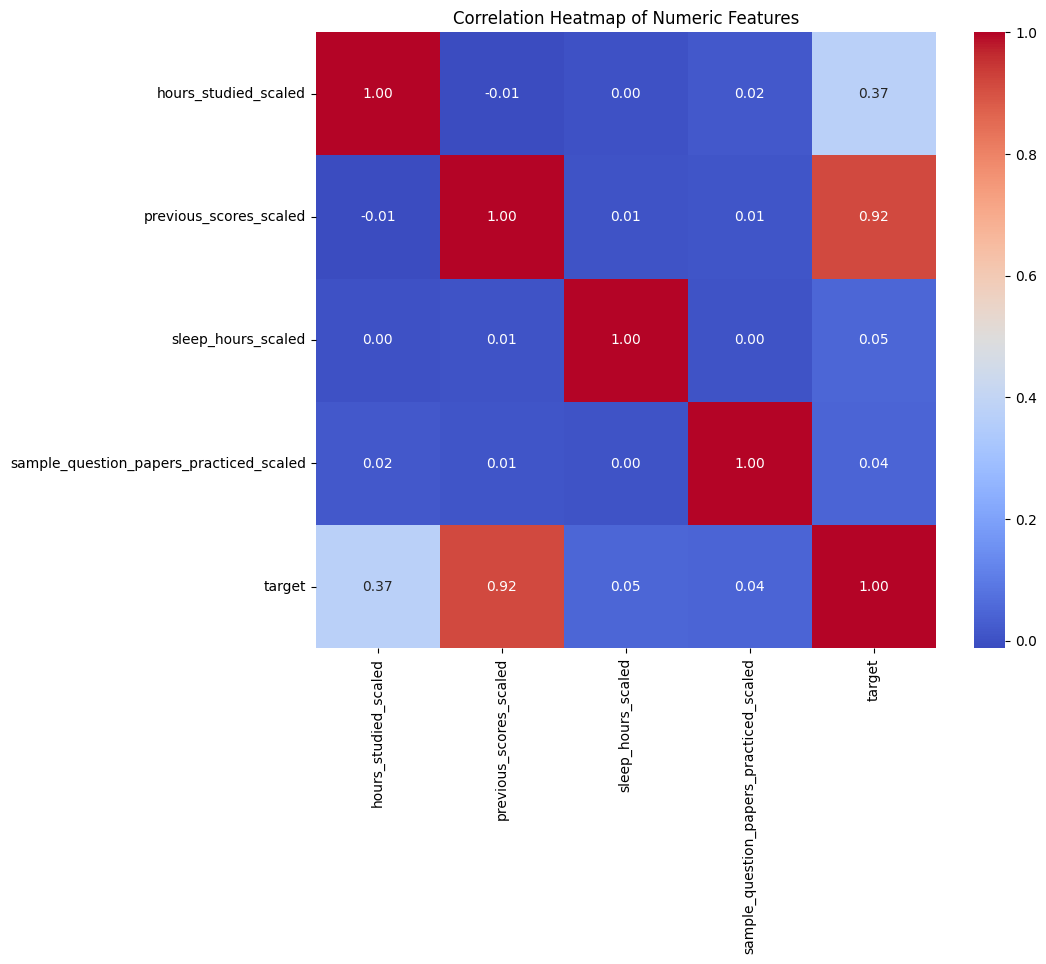

In [81]:
plt.figure(figsize=(10, 8))
corr_matrix = final_df[numeric_features+['target']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numeric Features')
plt.savefig('correlation_heatmap.png')
plt.show()
plt.close()


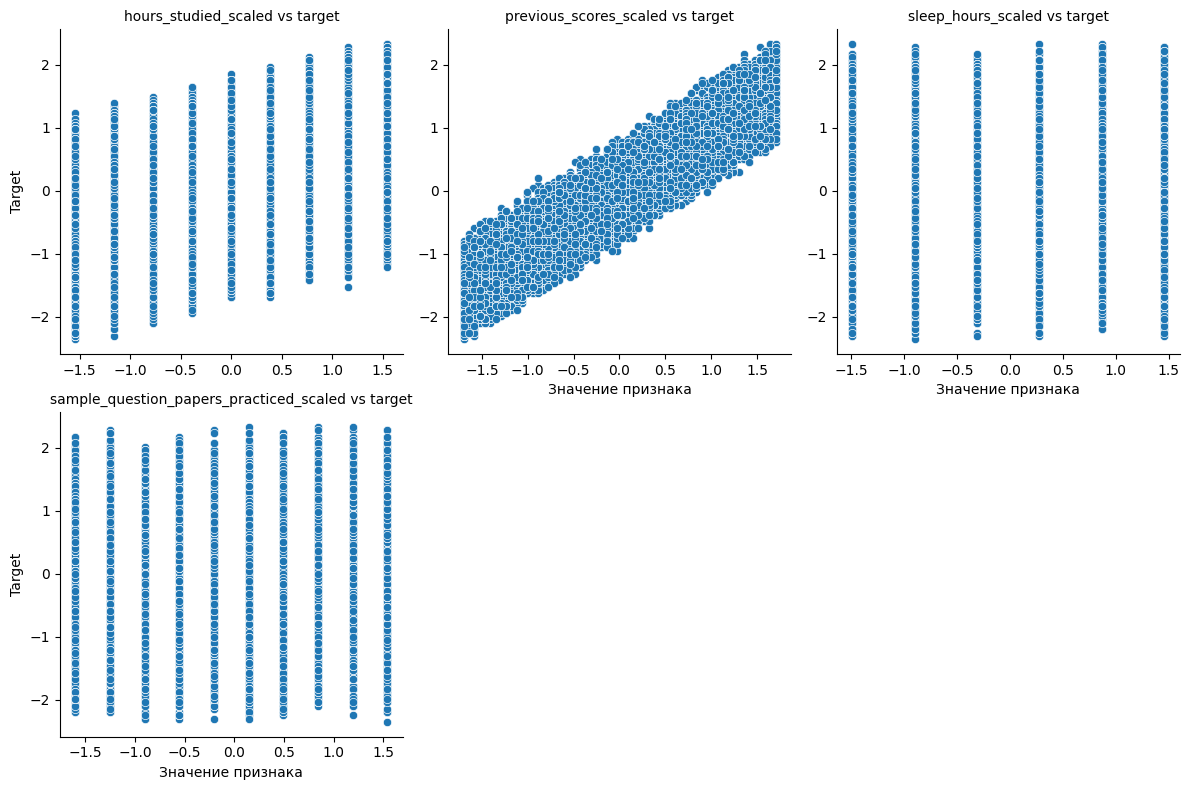

In [82]:
df_melted = pd.melt(final_df, id_vars=['target'], value_vars=numeric_features, var_name='feature', value_name='value')
g = sns.FacetGrid(df_melted, col='feature', col_wrap=3, height=4, sharex=False, sharey=False)
g.map(sns.scatterplot, 'value', 'target')
g.set_titles('{col_name} vs target')
g.set_xlabels('Значение признака')
g.set_ylabels('Target')
plt.savefig('facetgrid_numeric.png')
plt.show()
plt.close()

In [83]:
X = final_df.drop('target', axis=1)
y = final_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_num, X_test_num = X_train[numeric_features], X_test[numeric_features]
X_train_cat, X_test_cat = X_train[categorical_features], X_test[categorical_features]
feature_names_num = X_train_num.columns

# Задание 3-4

Обучить модель линейной регрессии LinearRegression.
<br>Вывести метрики MSE, MAE и R2 на тестовом наборе.
<br>Вывести model.coef_ и model.intercept_.
<br>Построить график (barh) с важностью коэфициентов при соответствующих признаках (сверху вниз расположены коэффициенты по убыванию, а названия соответствующих признаков подписаны по вертикальной оси).
<br>С использованием GridSearchCV осуществить подбор параметров регуляризации (alpha для Ridge и LASSO, alpha и l1_ratio для Elastic Net)
<br>Вывести значения гиперпараметров, коэффициенты регрессии (model.coef_ и model.intercept_) и значения метрик на тестовом наборе для наилучшей модели (MSE, MAE и R2).
<br>Построить график (barh) с важностью коэфициентов при соответствующих признаках (сверху вниз расположены коэффициенты по убыванию, а названия соответствующих признаков подписаны по вертикальной оси).

In [84]:
def print_metrics_and_coeffs(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"\n{model_name} Results:")
    print(f"MSE: {mse:.8f}")
    print(f"MAE: {mae:.8f}")
    print(f"R²: {r2:.8f}")
    print(f"Coefficients: {model.coef_}")
    print(f"Intercept: {model.intercept_}")
    return y_pred

def plot_feature_importance(coefs, feature_names, model_name):
    plt.figure(figsize=(10, 6))
    sorted_idx = np.argsort(np.abs(coefs))[::-1]  # Sort by absolute value, descending
    plt.barh(range(len(coefs)), coefs[sorted_idx], align='center')
    plt.yticks(range(len(coefs)), feature_names[sorted_idx])
    plt.xlabel('Coefficient Value')
    plt.title(f'Feature Importance - {model_name}')
    plt.gca().invert_yaxis()  # Top-down order
    plt.tight_layout()
    plt.show()
    plt.savefig(f'{model_name.lower().replace(" ", "_")}_feature_importance.png')
    plt.close()


Linear Regression Results:
MSE: 0.01133140
MAE: 0.08482755
R²: 0.98871446
Coefficients: [0.38448927 0.91807689 0.04177908 0.02861389]
Intercept: 0.0008272934478645395


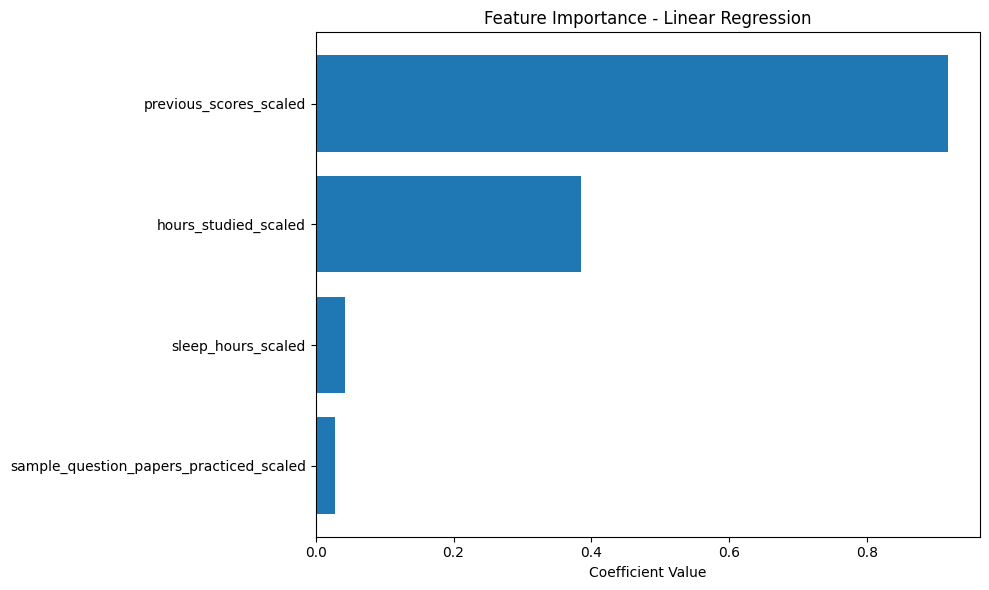

In [85]:
lr_model = LinearRegression()
lr_model.fit(X_train_num, y_train)
print_metrics_and_coeffs(lr_model, X_test_num, y_test, "Linear Regression")
plot_feature_importance(lr_model.coef_, feature_names_num, "Linear Regression")


Можно увидеть, что MSE и MAE близко к 0, а R² близко к 1, то есть ошибка очень мала и количество данных которые мы можем объяснить очень велико.


Best Ridge Parameters: {'alpha': 0.01}

Ridge Regression Results:
MSE: 0.01133142
MAE: 0.08482761
R²: 0.98871444
Coefficients: [0.38448878 0.91807573 0.04177903 0.02861387]
Intercept: 0.0008272977984773596


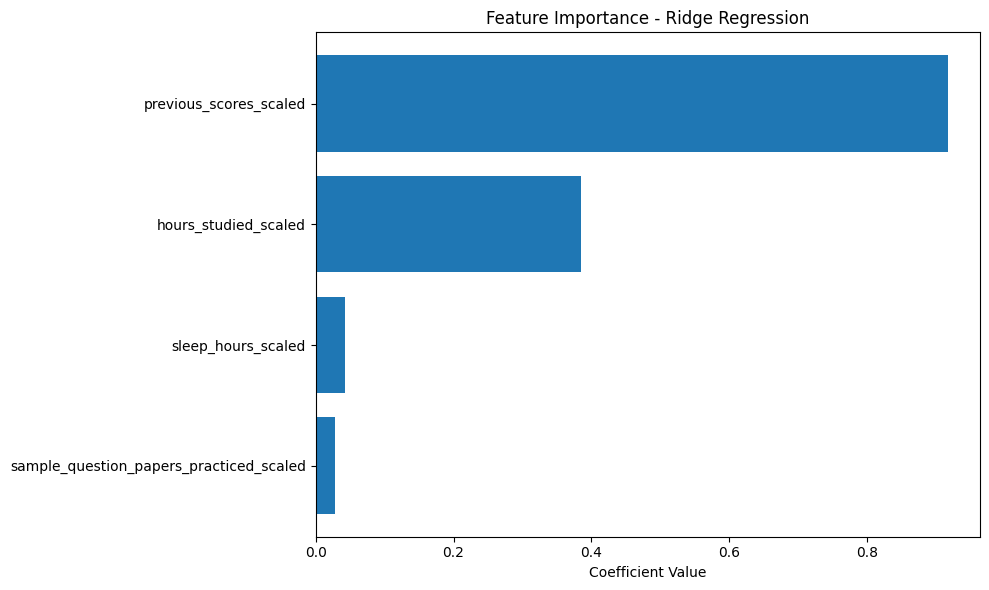

In [86]:
ridge_params = {'alpha': [0.01, 0.1, 1, 10, 100]}
ridge_grid = GridSearchCV(Ridge(), ridge_params, cv=5, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train_num, y_train)
best_ridge = ridge_grid.best_estimator_
print(f"\nBest Ridge Parameters: {ridge_grid.best_params_}")
print_metrics_and_coeffs(best_ridge, X_test_num, y_test, "Ridge Regression")
plot_feature_importance(best_ridge.coef_, feature_names_num, "Ridge Regression")

Можем увидеть то же


Best LASSO Parameters: {'alpha': 0.001}

LASSO Regression Results:
MSE: 0.01135813
MAE: 0.08492073
R²: 0.98868784
Coefficients: [0.38350364 0.91707642 0.04078935 0.02763469]
Intercept: 0.0008463138780089338


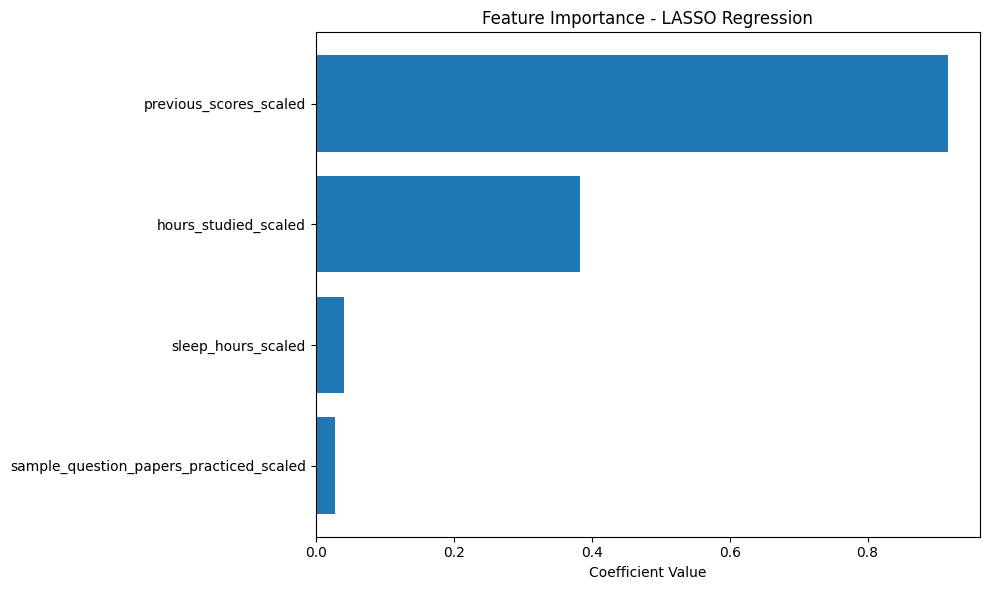

In [87]:
lasso_params = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
lasso_grid = GridSearchCV(Lasso(), lasso_params, cv=5, scoring='neg_mean_squared_error')
lasso_grid.fit(X_train_num, y_train)
best_lasso = lasso_grid.best_estimator_
print(f"\nBest LASSO Parameters: {lasso_grid.best_params_}")
print_metrics_and_coeffs(best_lasso, X_test_num, y_test, "LASSO Regression")
plot_feature_importance(best_lasso.coef_, feature_names_num, "LASSO Regression")

Можем увидеть то же


Best Elastic Net Parameters: {'alpha': 0.01, 'l1_ratio': 0.1}

Elastic Net Regression Results:
MSE: 0.01158022
MAE: 0.08565539
R²: 0.98846664
Coefficients: [0.38001303 0.90886013 0.04044966 0.02752392]
Intercept: 0.0008772080102928273


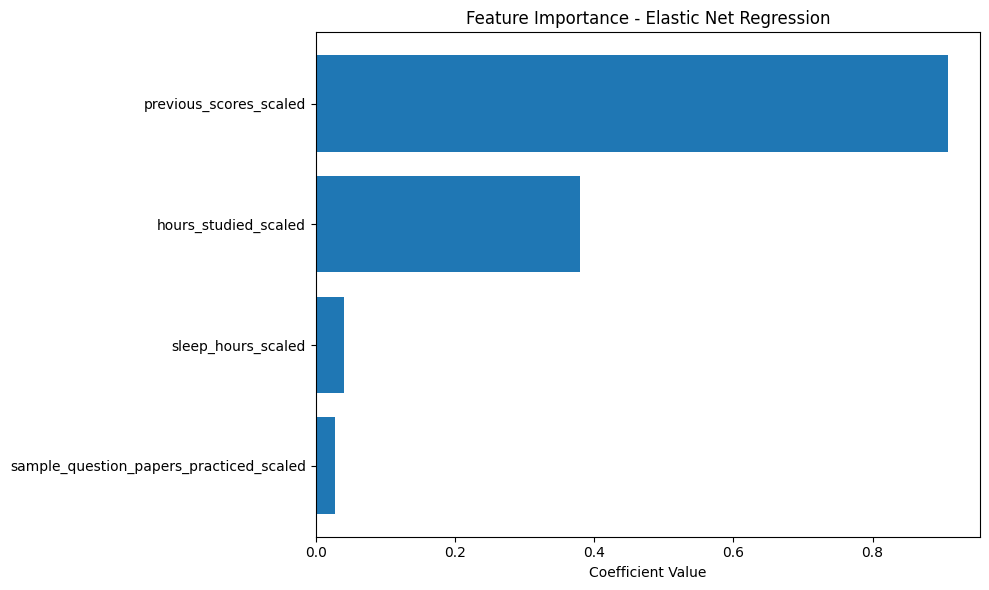

In [88]:
enet_params = {'alpha': [0.01, 0.1, 1, 10], 'l1_ratio': [0.1, 0.5, 0.9]}
enet_grid = GridSearchCV(ElasticNet(), enet_params, cv=5, scoring='neg_mean_squared_error')
enet_grid.fit(X_train_num, y_train)
best_enet = enet_grid.best_estimator_
print(f"\nBest Elastic Net Parameters: {enet_grid.best_params_}")
print_metrics_and_coeffs(best_enet, X_test_num, y_test, "Elastic Net Regression")
plot_feature_importance(best_enet.coef_, feature_names_num, "Elastic Net Regression")

Можем увидеть то же

In [89]:
def print_metrics_and_coeffs(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"\n{model_name} Results:")
    print(f"MSE: {mse:.8f}")
    print(f"MAE: {mae:.8f}")
    print(f"R²: {r2:.8f}")
    #print(f"Coefficients: {model.coef_}")
    #print(f"Intercept: {model.intercept_}")
    return y_pred

In [90]:
lr_metrics = print_metrics_and_coeffs(lr_model, X_test_num, y_test, "Linear Regression")
ridge_metrics = print_metrics_and_coeffs(best_ridge, X_test_num, y_test, "Ridge Regression")
lasso_metrics = print_metrics_and_coeffs(best_lasso, X_test_num, y_test, "LASSO Regression")
enet_metrics = print_metrics_and_coeffs(best_enet, X_test_num, y_test, "Elastic Net Regression")


Linear Regression Results:
MSE: 0.01133140
MAE: 0.08482755
R²: 0.98871446

Ridge Regression Results:
MSE: 0.01133142
MAE: 0.08482761
R²: 0.98871444

LASSO Regression Results:
MSE: 0.01135813
MAE: 0.08492073
R²: 0.98868784

Elastic Net Regression Results:
MSE: 0.01158022
MAE: 0.08565539
R²: 0.98846664


In [91]:
best_models = {
    'LinearRegression': lr_model,
    'Ridge': best_ridge,
    'LASSO': best_lasso,
    'ElasticNet': best_enet
}

In [92]:
best_models

{'LinearRegression': LinearRegression(),
 'Ridge': Ridge(alpha=0.01),
 'LASSO': Lasso(alpha=0.001),
 'ElasticNet': ElasticNet(alpha=0.01, l1_ratio=0.1)}

# Задание 5 выполнялось в задании 2

# Задание 6

Обучить LinearRegression, лучшие модели Ridge, LASSO, Elastic Net на обучающем наборе с категориальными признаками.
<br>Вывести значения гиперпараметров, коэффициенты регрессии (model.coef_ и model.intercept_) и значения метрик на тестовом наборе (MSE, MAE и R2).
<br>Сравнить метрики с наличием категориальных признаков и без для каждой из моделей.
<br>Выбрать лучшую модель.
<br>Построить график (barh) с важностью коэфициентов при соответствующих признаках (сверху вниз расположены коэффициенты по убыванию, а названия соответствующих признаков <br>подписаны по вертикальной оси).
<br>Осуществить фильтрацию признаков с использованием Recursive Feature Elimination.
<br>Построить график (barh) с важностью коэфициентов при соответствующих признаках (сверху вниз расположены коэффициенты по убыванию, а названия соответствующих признаков подписаны по вертикальной оси).
<br>Вывести значения метрик на тестовом наборе (MSE, MAE и R2).

In [93]:
def print_metrics_and_coeffs(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"\n{model_name} Results:")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"Coefficients: {model.coef_}")
    print(f"Intercept: {model.intercept_}")
    return y_pred

def plot_feature_importance(coefs, feature_names, model_name):
    plt.figure(figsize=(10, 8))
    sorted_idx = np.argsort(np.abs(coefs))[::-1]  # Sort by absolute value, descending
    plt.barh(range(len(coefs)), coefs[sorted_idx], align='center')
    plt.yticks(range(len(coefs)), feature_names[sorted_idx])
    plt.xlabel('Coefficient Value')
    plt.title(f'Feature Importance - {model_name}')
    plt.gca().invert_yaxis()  # Top-down order
    plt.tight_layout()
    plt.show()
    plt.savefig(f'{model_name.lower().replace(" ", "_")}_feature_importance.png')
    plt.close()

In [94]:
feature_names = X_train.columns
feature_names

Index(['hours_studied_scaled', 'previous_scores_scaled', 'sleep_hours_scaled',
       'sample_question_papers_practiced_scaled',
       'extracurricular_activities'],
      dtype='object')


Linear Regression Results:
MSE: 0.0113
MAE: 0.0843
R²: 0.9887
Coefficients: [0.38443407 0.91803399 0.04209889 0.02862958 0.03167965]
Intercept: -0.014844509288221428


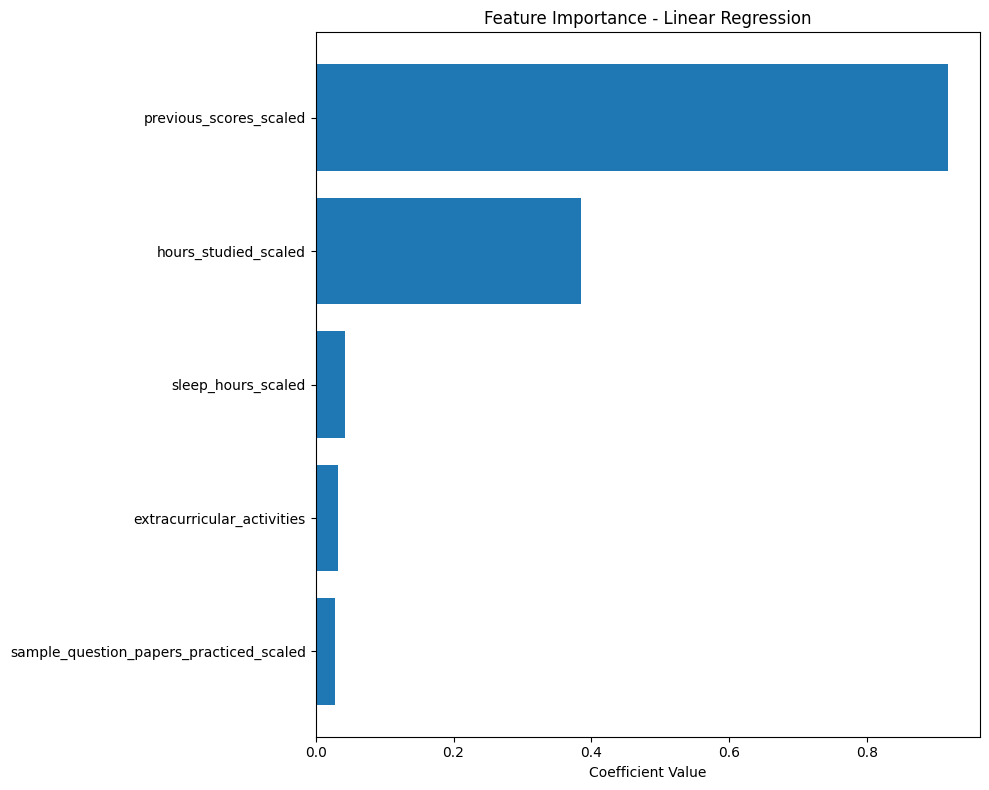

In [95]:
# модель работает хорошо
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
print_metrics_and_coeffs(lr_model, X_train, y_train, "Linear Regression")
plot_feature_importance(lr_model.coef_, feature_names, "Linear Regression")

В целом, точность увеличилась, но какая то проблема к коэффициентами


Best Ridge Parameters: {'alpha': 0.01}

Ridge Regression Results:
MSE: 0.0111
MAE: 0.0839
R²: 0.9890
Coefficients: [0.38443358 0.91803284 0.04209884 0.02862956 0.0316795 ]
Intercept: -0.014844430180557942


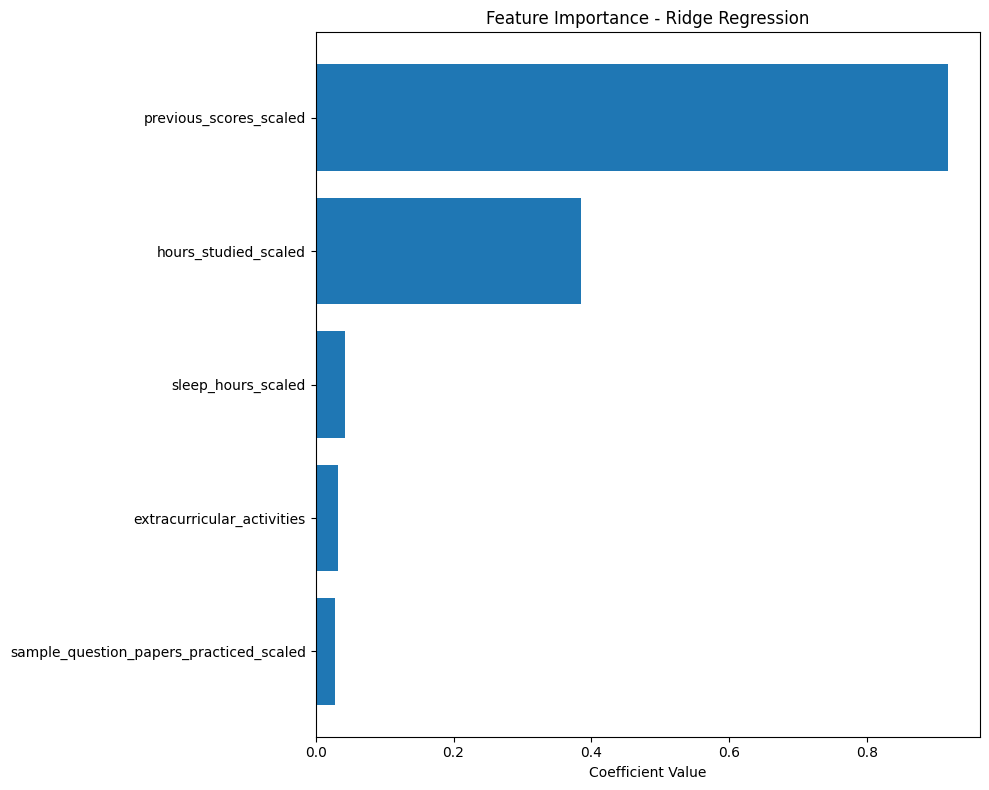

In [96]:
ridge_params = {'alpha': [0.01, 0.1, 1, 10, 100]}
ridge_grid = GridSearchCV(Ridge(), ridge_params, cv=5, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train, y_train)
best_ridge = ridge_grid.best_estimator_
print(f"\nBest Ridge Parameters: {ridge_grid.best_params_}")
print_metrics_and_coeffs(best_ridge, X_test, y_test, "Ridge Regression")
plot_feature_importance(best_ridge.coef_, feature_names, "Ridge Regression")

Точность лучше, с коэффициентами все хорошо


Best LASSO Parameters: {'alpha': 0.001}

LASSO Regression Results:
MSE: 0.0111
MAE: 0.0839
R²: 0.9890
Coefficients: [0.38345546 0.91703899 0.04106845 0.02764839 0.02764748]
Intercept: -0.012830790526150104


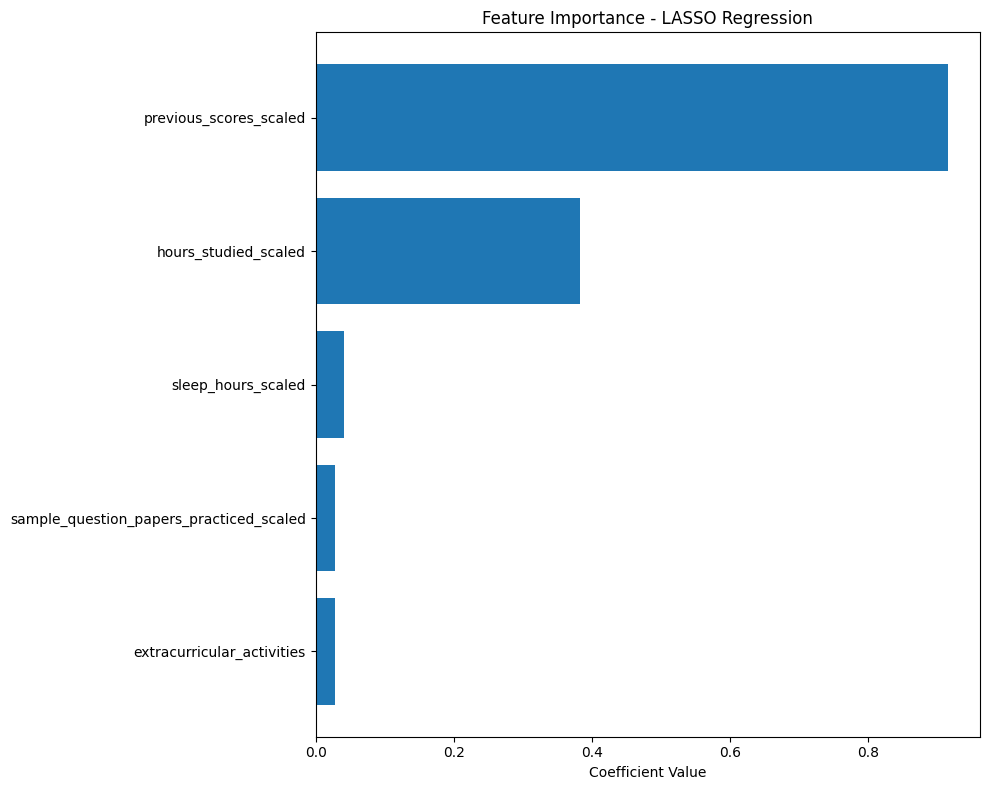

In [97]:
lasso_params = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
lasso_grid = GridSearchCV(Lasso(), lasso_params, cv=5, scoring='neg_mean_squared_error')
lasso_grid.fit(X_train, y_train)
best_lasso = lasso_grid.best_estimator_
print(f"\nBest LASSO Parameters: {lasso_grid.best_params_}")
print_metrics_and_coeffs(best_lasso, X_test, y_test, "LASSO Regression")
plot_feature_importance(best_lasso.coef_, feature_names, "LASSO Regression")

Точность лучше чем в обычной линейной регрессии, с коэффициентами все хорошо


Best Elastic Net Parameters: {'alpha': 0.01, 'l1_ratio': 0.1}

Elastic Net Regression Results:
MSE: 0.0113
MAE: 0.0847
R²: 0.9887
Coefficients: [0.37996687 0.90882426 0.04071717 0.02753704 0.02673729]
Intercept: -0.012349610313259238


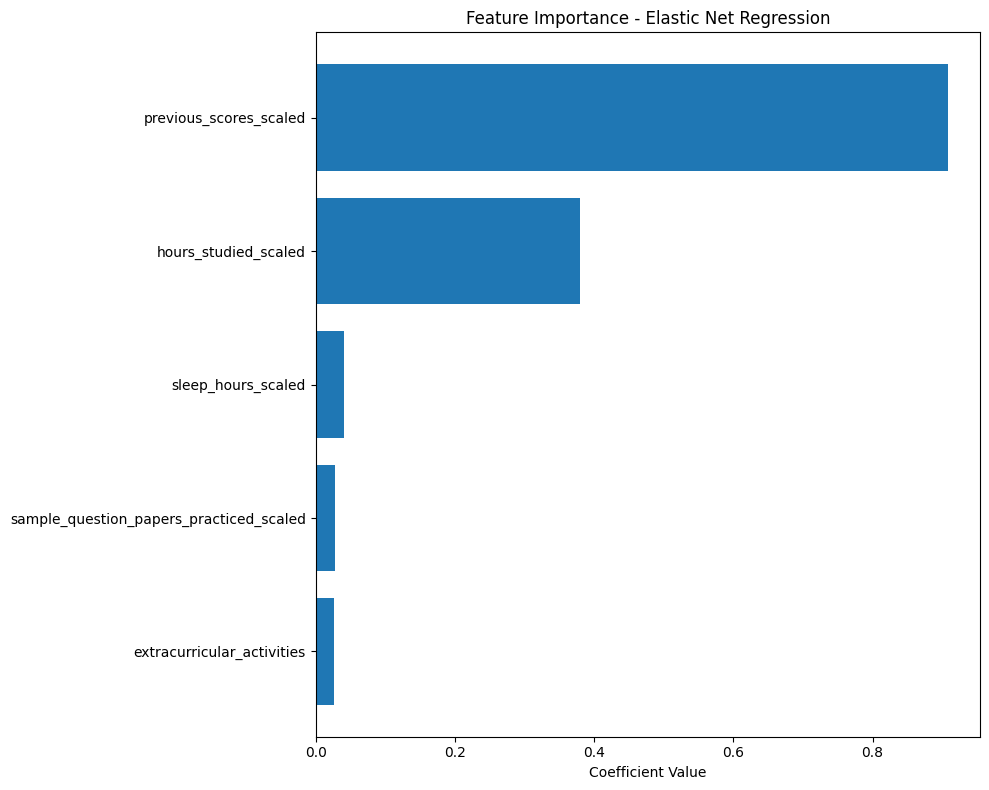

In [98]:
enet_params = {'alpha': [0.01, 0.1, 1, 10], 'l1_ratio': [0.1, 0.5, 0.9]}
enet_grid = GridSearchCV(ElasticNet(), enet_params, cv=5, scoring='neg_mean_squared_error')
enet_grid.fit(X_train, y_train)
best_enet = enet_grid.best_estimator_
print(f"\nBest Elastic Net Parameters: {enet_grid.best_params_}")
print_metrics_and_coeffs(best_enet, X_test, y_test, "Elastic Net Regression")
plot_feature_importance(best_enet.coef_, feature_names, "Elastic Net Regression")

In [99]:
def print_metrics_and_coeffs(model, X, y, model_name):
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print(f"\n{model_name} Results:")
    print(f"MSE: {mse:.8f}")
    print(f"MAE: {mae:.8f}")
    print(f"R²: {r2:.8f}")
    #print(f"Coefficients: {model.coef_}")
    #print(f"Intercept: {model.intercept_}")
    
    return mse, mae, r2

In [100]:
lr_metrics = print_metrics_and_coeffs(lr_model, X_test, y_test, "Linear Regression Categories")
ridge_metrics = print_metrics_and_coeffs(best_ridge, X_test, y_test, "Ridge Regression Categories")
lasso_metrics = print_metrics_and_coeffs(best_lasso, X_test, y_test, "LASSO Regression Categories")
enet_metrics = print_metrics_and_coeffs(best_enet, X_test, y_test, "Elastic Net Regression Categories")


Linear Regression Categories Results:
MSE: 0.01106147
MAE: 0.08386192
R²: 0.98898329

Ridge Regression Categories Results:
MSE: 0.01106149
MAE: 0.08386197
R²: 0.98898328

LASSO Regression Categories Results:
MSE: 0.01109237
MAE: 0.08394371
R²: 0.98895252

Elastic Net Regression Categories Results:
MSE: 0.01131045
MAE: 0.08470761
R²: 0.98873532


Можно увидеть, что обычная Линейная регрессия отработала лучше всего, можно предположить, что это из-за того, что категориальные признаки вносят не очень значимы

In [101]:
models = {
    'Linear Regression': (lr_model, lr_metrics[2]),
    'Ridge': (best_ridge, ridge_metrics[2]),
    'LASSO': (best_lasso, lasso_metrics[2]),
    'Elastic Net': (best_enet, enet_metrics[2])
}
best_model_name, (best_model, best_r2) = max(models.items(), key=lambda x: x[1][1])
print(f"\nBest model selected: {best_model_name} with R² = {best_r2:.4f}")

if best_model_name == 'Linear Regression':
    estimator = LinearRegression()
elif best_model_name == 'Ridge':
    estimator = Ridge(alpha=best_ridge.alpha)
elif best_model_name == 'LASSO':
    estimator = Lasso(alpha=best_lasso.alpha)
elif best_model_name == 'Elastic Net':
    estimator = ElasticNet(alpha=best_enet.alpha, l1_ratio=best_enet.l1_ratio)



Best model selected: Linear Regression with R² = 0.9890


In [102]:
selector = RFECV(estimator, cv=5, scoring='neg_mean_squared_error')
selector.fit(X_train, y_train)
selected_features = X_train.columns[selector.support_]
print(f"Выбранные признаки: {list(selected_features)}")

Выбранные признаки: ['hours_studied_scaled', 'previous_scores_scaled', 'sleep_hours_scaled', 'sample_question_papers_practiced_scaled', 'extracurricular_activities']


Можно увидеть, что признаки не изменились


Linear Regression Results:
MSE: 0.01106147
MAE: 0.08386192
R²: 0.98898329


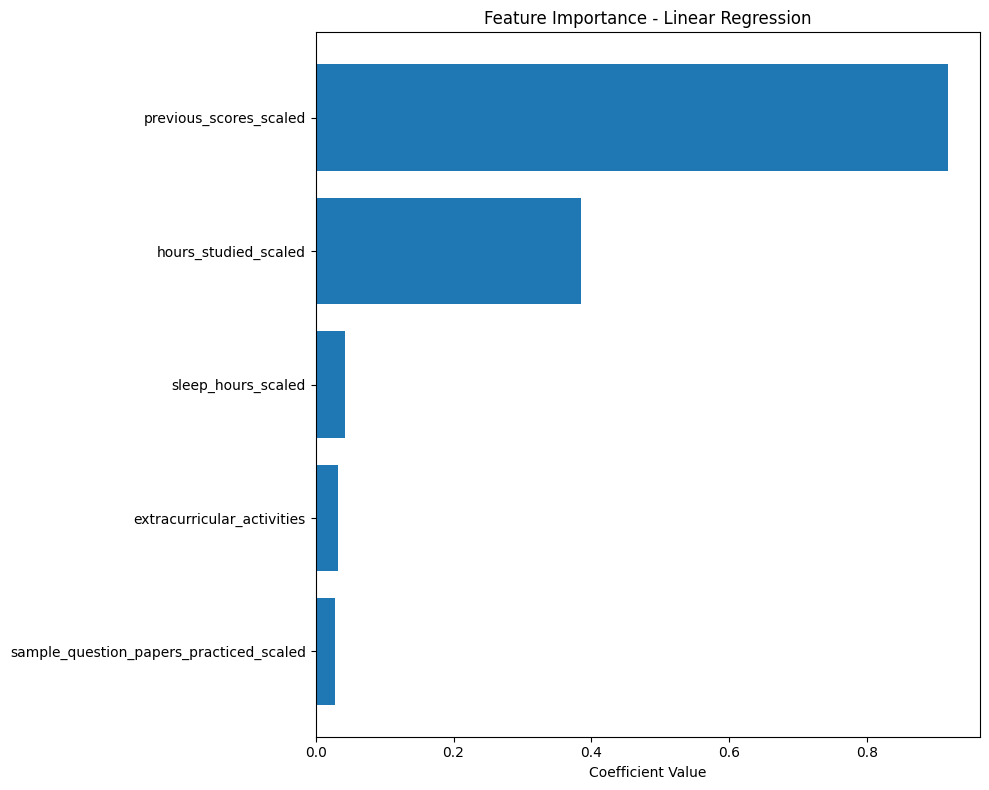

In [103]:
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]
best_model.fit(X_train_selected, y_train)

print_metrics_and_coeffs(best_model, X_test_selected, y_test, best_model_name)


plot_feature_importance(best_model.coef_, selected_features, best_model_name)

# Задание 7

| Модель                 | Признак          | MSE         | MAE         | R²          |
|------------------------|------------------|-------------|-------------|-------------|
| **Linear Regression**  | Numeric Only     | 0.01133140  | 0.08482755  | 0.98871446  |
| Ridge Regression       | Numeric Only     | 0.01133142  | 0.08482761  | 0.98871444  |
| LASSO Regression       | Numeric Only     | 0.01135813  | 0.08492073  | 0.98868784  |
| Elastic Net Regression | Numeric Only     | 0.01158022  | 0.08565539  | 0.98846664  |
| **Linear Regression**  | With Categories  | 0.01106147  | 0.08386192  | 0.98898329  |
| Ridge Regression       | With Categories  | 0.01106149  | 0.08386197  | 0.98898328  |
| LASSO Regression       | With Categories  | 0.01109237  | 0.08394371  | 0.98895252  |
| Elastic Net Regression | With Categories  | 0.01131045  | 0.08470761  | 0.98873532  |

В целом можем увидеть, что все модели справилить хорошо с задачей. Лучшей моделью для данного датасета оказалась обычная линейная регрессия. Если сравнивать с категориальными и без, то с категориальными данными отработало чуть лучше.